# Brain tumor segmentation

- The segmentation-models-pytorch is a deep learning package used for image segmentation tasks 

In [19]:
pip install seaborn

14184.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# installing packages
# this is a very large package take your time 
pip install --default-timeout=120 segmentation-models-pytorch

In [21]:
pip install -q opencv-python # -q for quiet

14297.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install -q albumentations

14477.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os # provides a way to interact with the operating system
import time
from glob import glob # used for pattern matching files and directories in a file system.
from tqdm import tqdm # progress indicator for tasks that involve iteration

In [3]:
import cv2 # open source computer vision package used in computer vision applications, image and video processing
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A # for image augmentation 
from scipy.ndimage.morphology import binary_dilation # used for morphological operations on binary (boolean) images
import segmentation_models_pytorch as smp
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split


/tmp/ipykernel_28540/3205484774.py:7: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation # used for morphological operations on binary (boolean) images


In [4]:
import torch
from torch.optim import Adam # Adaptive Moment Estimation is an optimization algorithm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms as T

In [5]:
# check for CUDA compatible GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing

In [6]:
# getting files 
files_dir = '/media/danlof/USB STICK/MRI/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

# loading files 
csv_path = '/media/danlof/USB STICK/MRI/kaggle_3m/data.csv'
mri_df = pd.read_csv(csv_path)
mri_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [28]:
mri_df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


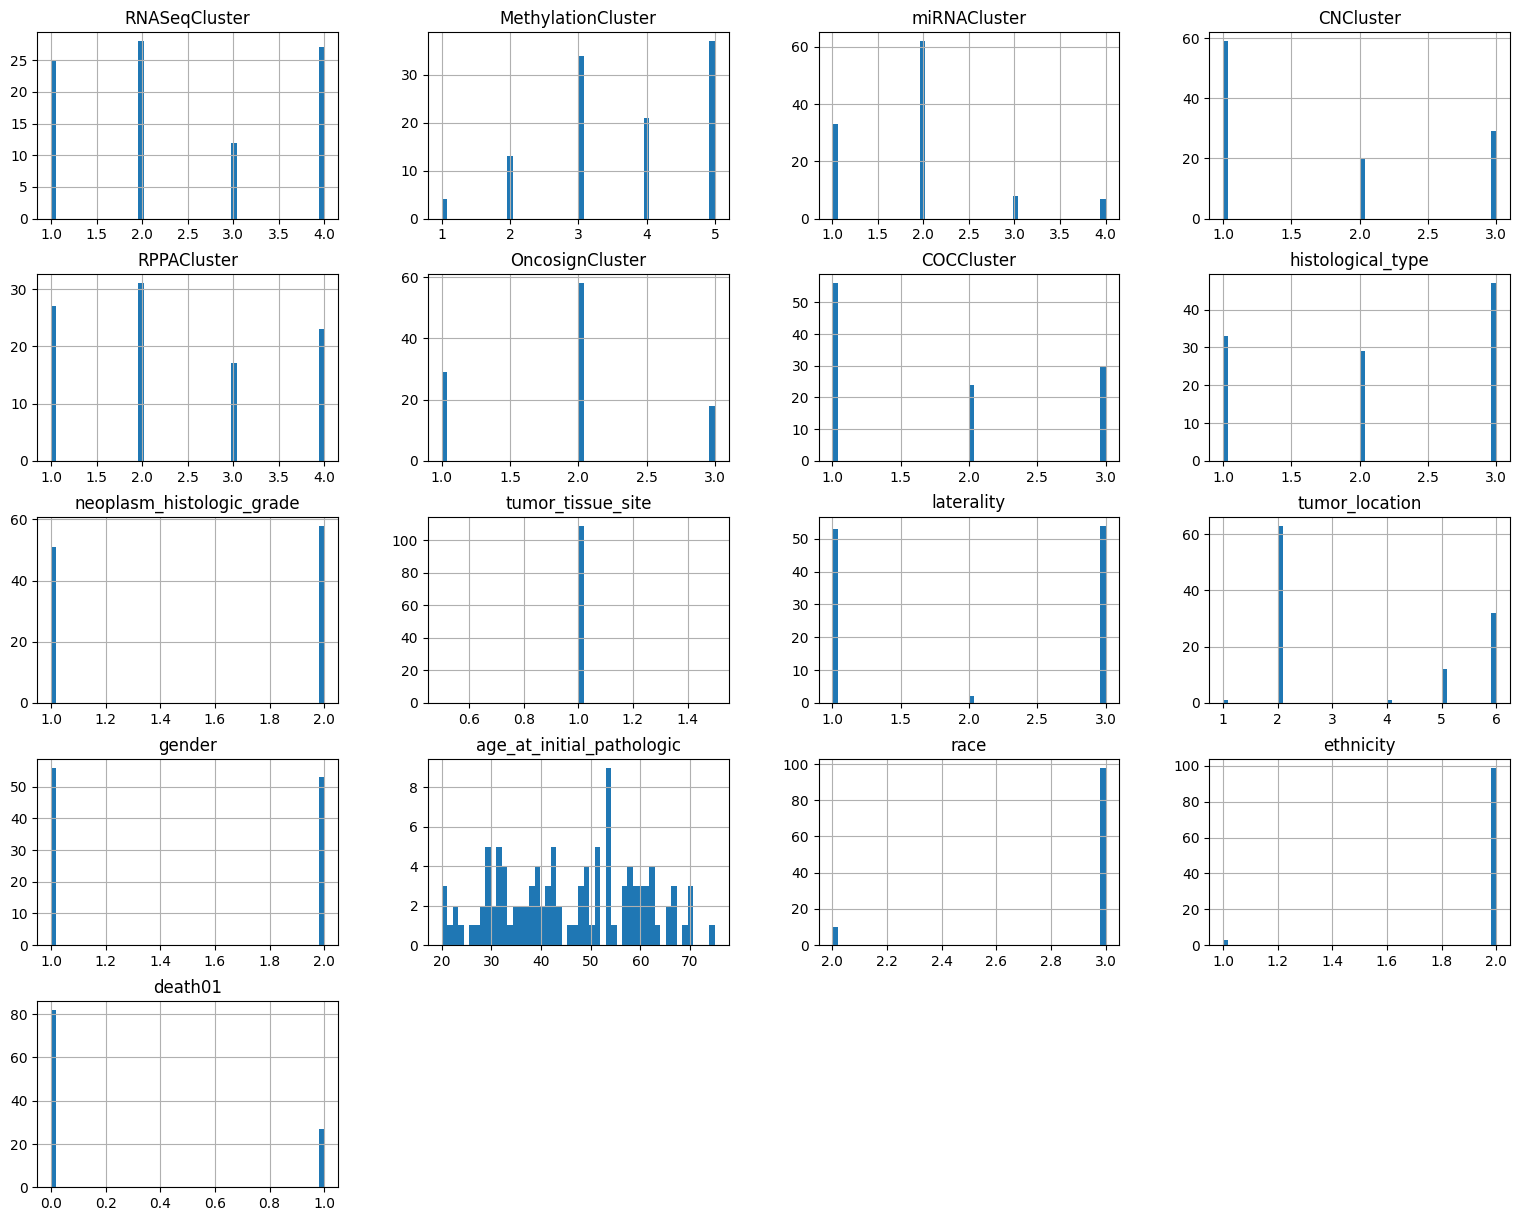

In [29]:
%matplotlib inline
mri_df.hist(bins = 50 ,figsize= (19,15))
plt.show()

## How to handle missing values

- I will be having the simple imputer on the most frequent when dealing with missing values and 
- I will also perform KNN imputation and compare both for accuracy

- 1. Simple Imputer

In [30]:
imputer = SimpleImputer(missing_values=np.nan,strategy= 'most_frequent')
imputer = imputer.fit(mri_df.values)
df_SI = pd.DataFrame(imputer.transform(mri_df.values),columns=mri_df.columns)
df_SI.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0


- 2. KNN imputer

In [7]:
non_numeric = mri_df.select_dtypes(exclude = 'number')
numeric = mri_df.select_dtypes(include= 'number')
# specify the number of k neighbours
n_neighbours = 5
# create a KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=n_neighbours)
# fit the knn imputer
df_knn = knn_imputer.fit_transform(numeric)
df_knn = pd.DataFrame(df_knn,columns = numeric.columns)
knn_df = pd.concat([non_numeric,df_knn],axis=1)
knn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              110 non-null    float64
 2   MethylationCluster         110 non-null    float64
 3   miRNACluster               110 non-null    float64
 4   CNCluster                  110 non-null    float64
 5   RPPACluster                110 non-null    float64
 6   OncosignCluster            110 non-null    float64
 7   COCCluster                 110 non-null    float64
 8   histological_type          110 non-null    float64
 9   neoplasm_histologic_grade  110 non-null    float64
 10  tumor_tissue_site          110 non-null    float64
 11  laterality                 110 non-null    float64
 12  tumor_location             110 non-null    float64
 13  gender                     110 non-null    float64

In [8]:
# function for data retrival

def get_file_row(path):
    """produces patient ID,image and mask filenames from a particular path"""
    path_no_ext,ext = os.path.splitext(path)
    filename = os.path.basename(path)
    patient_id = '_'.join(filename.split('_')[:3])
    return [patient_id,path,f'{path_no_ext}_mask{ext}']


get_file_row('/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif')

['TCGA_DU_7010',
 '/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif']

In [9]:
# storing the data into a dataframe 

filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths),columns = ['Patient','image_filename','mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_CS_4941,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...
1,TCGA_CS_4941,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...
2,TCGA_CS_4941,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...
3,TCGA_CS_4941,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...
4,TCGA_CS_4941,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_CS_...
...,...,...,...
3924,TCGA_HT_A61B,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...
3925,TCGA_HT_A61B,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...
3926,TCGA_HT_A61B,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...
3927,TCGA_HT_A61B,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...,/media/danlof/USB STICK/MRI/kaggle_3m/TCGA_HT_...


### Custom dataset class for pyTorch dataset loader

The class below is a custom dataset class called MriDataset that does the following:
- Loads Mri images and their corresponding masks
- Applys optional data augmentation
- Normalize the data for use in pyTorch based machine learning 

In [10]:
class MriDataset(Dataset):
    def __init__(self,knn_df,transform = None,mean = 0.5,std = 0.25):
        super(MriDataset,self).__init__()
        self.knn_df = knn_df
        self.transform = transform
        self.mean = mean
        self.std = std


    def __len__(self):
        return len(self.knn_df)


    def __getitem__(self, idx, raw=False):
        row = self.knn_df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask   

        if self.transform:
            augmented = self.transform(image = img, mask = mask)
            image , mask = augmented['image'], augmented['mask']
            img =T.functional.to_tensor(img)
            mask = mask //255
            return img, mask

In [11]:
# merging the data from the files containing the mri images and their corresponding masks with 
# the knn imputed data
df = pd.merge(
    knn_df,
    filenames_df,
    on='Patient'
)

In [12]:
# splitting the dataset we just created and creating a validation dataframe

train_df , test_df = train_test_split(df,test_size = 0.3)
test_df,valid_df = train_test_split(test_df,test_size = 0.5)

### A transformation pipeline using albumentations

The pipeline below does the following:
- Simulates missing information in the image channels(channel dropout)
- Helps the model become more robust in variations of light( random brightness contrast)
- color jittering introduces random color pertubations to the image
and with a probability of 30% of each of them happening

In [13]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

## Create a dataloader

In [14]:
batch_size = 16 # this ensures that it loads 16 images at a time

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
valid_loader = DataLoader(valid_dataset,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1)# batchsize = 1 because you want to evaluate sampple independently 

## visualize some abnormal Mri from the train dataset

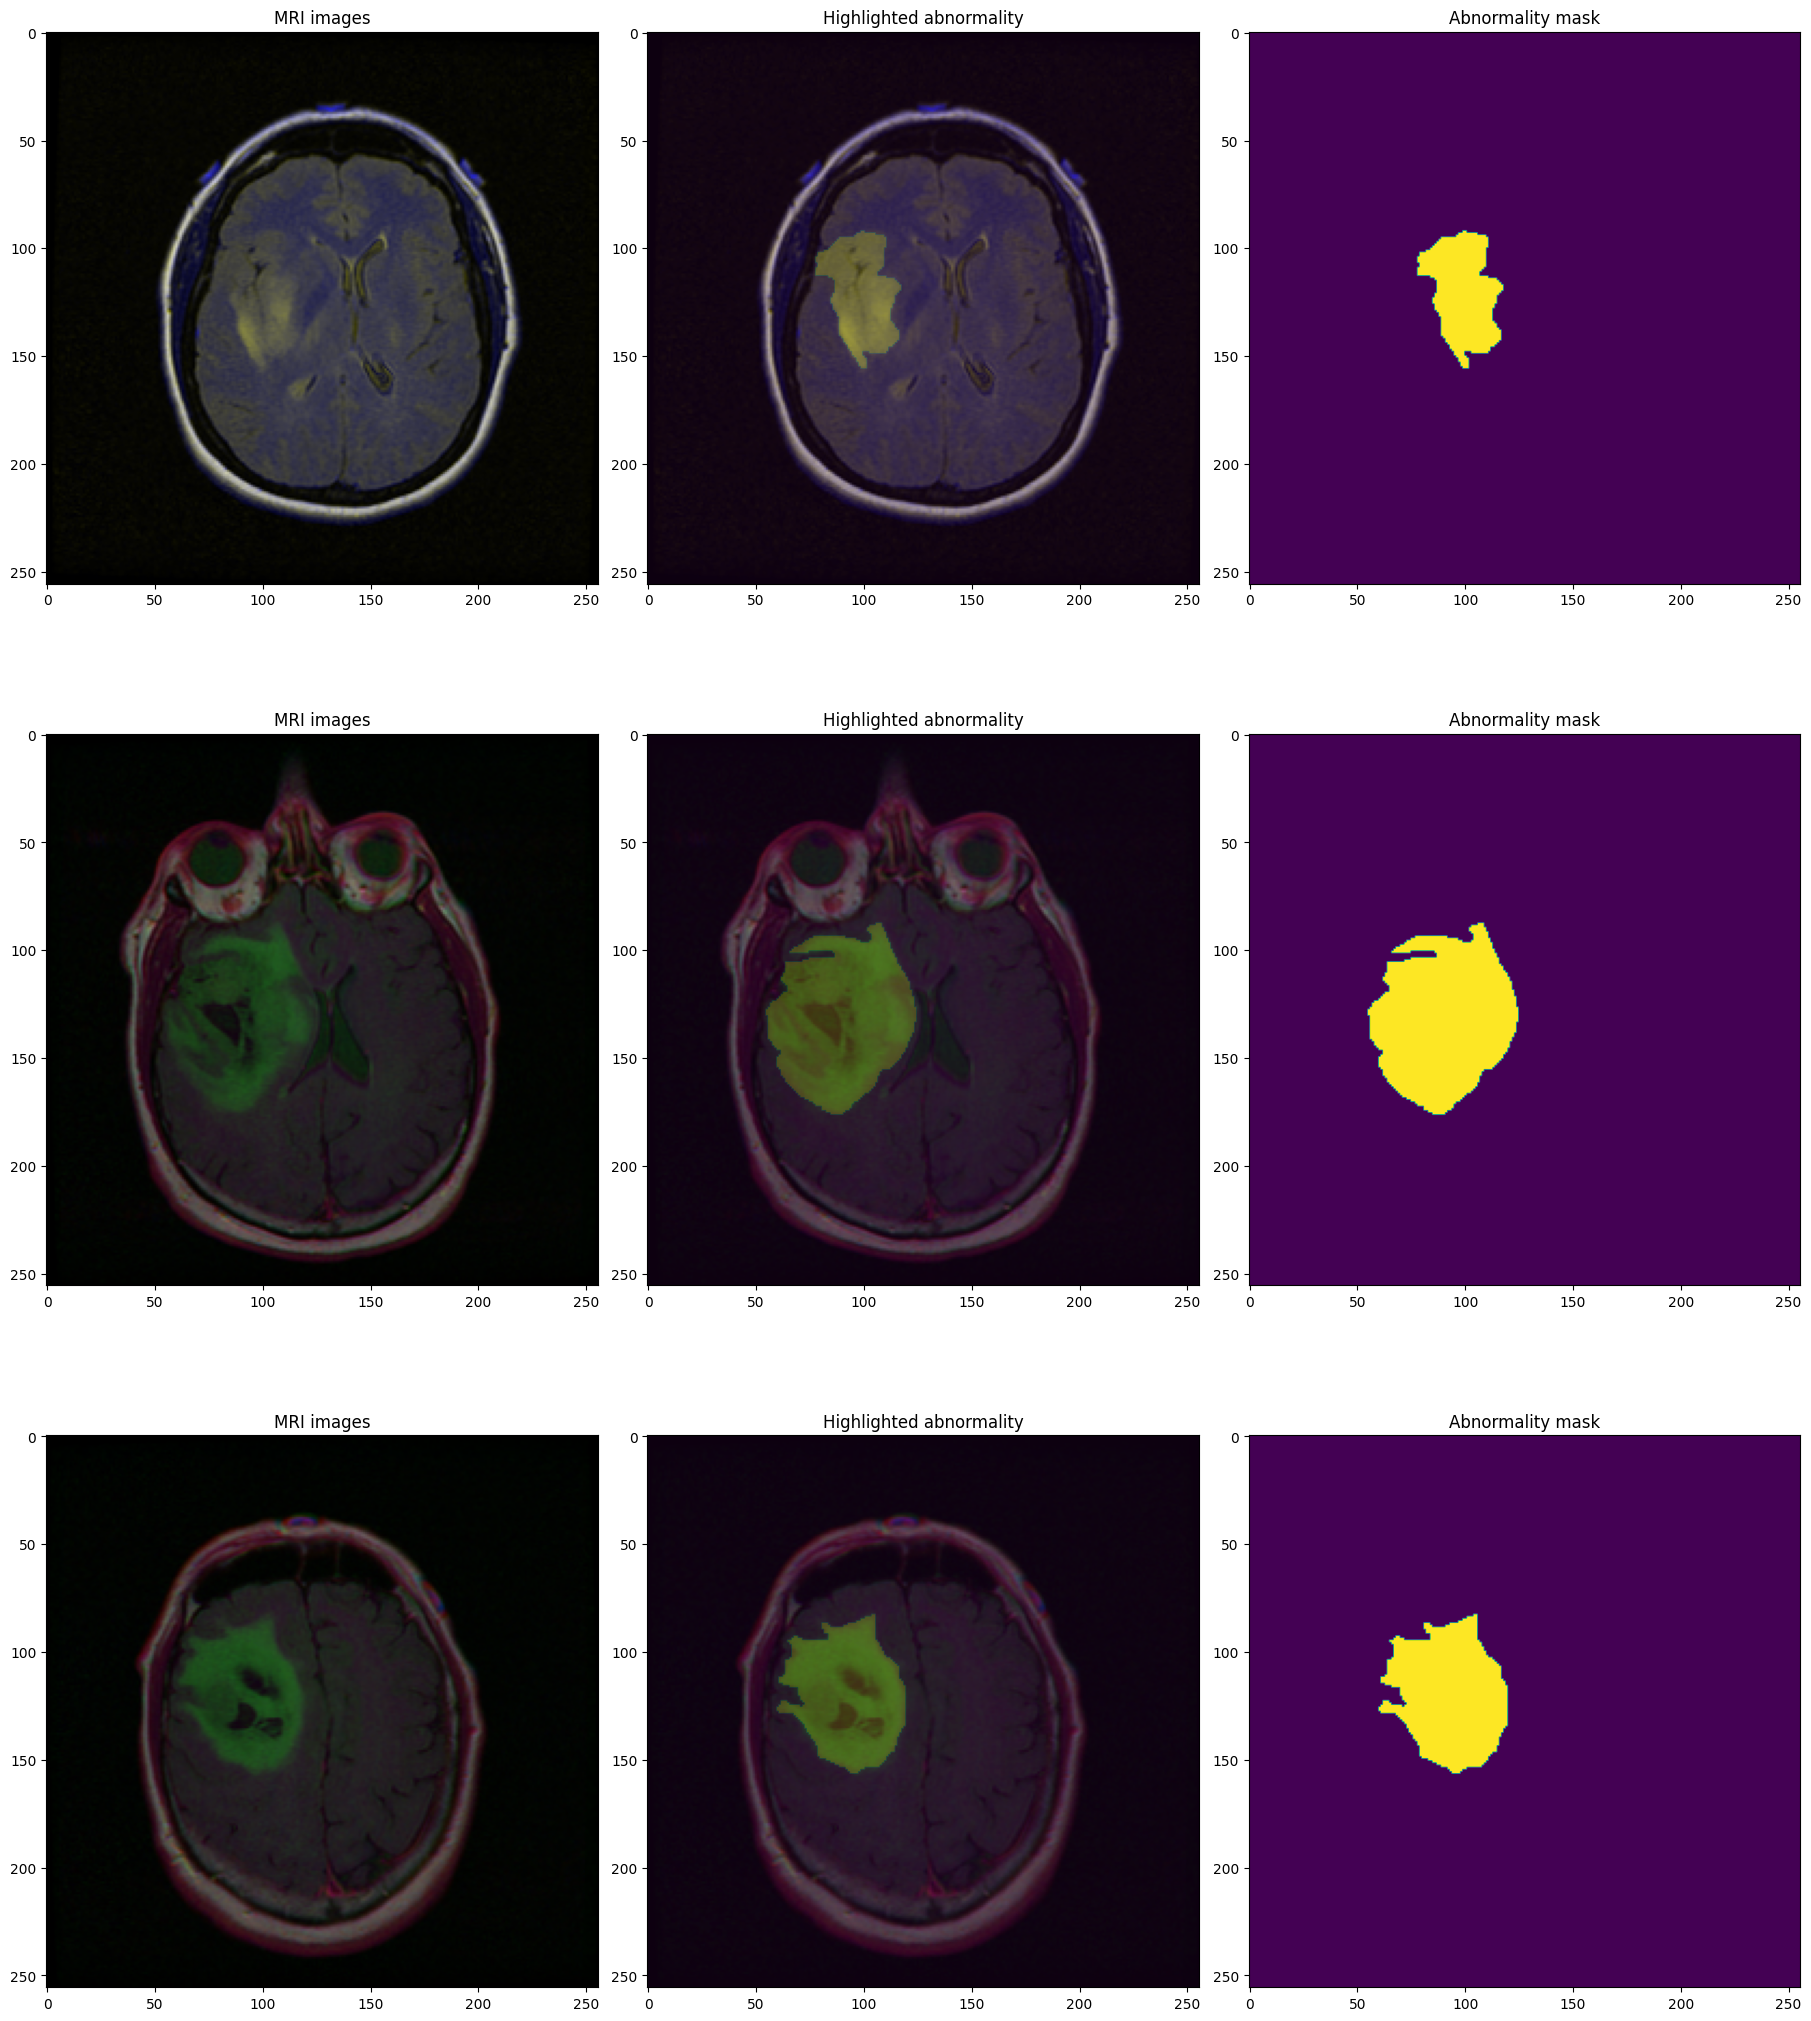

In [39]:
%matplotlib inline 
n_example = 3

fig,axs = plt.subplots(
    n_example,3, # rows, columns
    figsize = (18,n_example*7),# size of the plot
    constrained_layout= True
) 
i = 0

for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i,raw=True)
        i+=1
        if np.any(mask):
            ax[0].set_title('MRI images')
            ax[0].imshow(image)
            ax[1].set_title('Highlighted abnormality')
            ax[1].imshow(image)
            ax[1].imshow(mask,alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title('Abnormality mask')
            break 
            
        

## Create a class to monitor the validation loss during training

In [15]:
class EarlyStopping():
    def __init__(self,
                 patience:int = 6, # the number of non-degressing loss allowed before training stops
                 min_delta:float= 0,# the minimum difference btwn the lowest validation loss and the new validation loss that is considered an improvement
                 weights_path:str='weights.pt'# path to file where the models weights will be saved when the best loss is achieved 
                ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0 # keeps track of the no. of epochs without an improvemnt in the validation loss
        self.best_loss = float('inf') # reps the best validation loss seen so far
        self.weights_path = weights_path

    def __call__(self,val_loss:float,model:torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dic(),self.weights_path)
            self.counter = 0
        else:
            self.counter+=1
            if self.counter>=self.patience:
                return True
        return False
    def load_weights(self,model:torch.nn.Module):
        return model.load_state_dict(torch.load(self.weights_path))


## Evaluation metrics :intersection over Union(IoU) and Diverse counterfactual explanations(Dice)

- Iou : is metric for evaluation binary segmentation tasks , it quatifies the degree of overlap btwn the  predicted binary mask and the ground truth mask.
- Dice: Provide 'what if 'explanations to a model during evaluation , by providing an actionable path.

In [16]:
# metric 1: IoU
def iou_pytorch(predictions:torch.Tensor,labels:torch.Tensor,e:float = 1e-7):
    predictions = torch.where(predictions> 0.5,1,0)
    labels = labels.byte()
    intersection = (predictions & labels).float().sum((1,2))
    union = (predictions | labels).float().sum((1,2))
    iou  = (intersection + e)/(union + e)
    return iou 
# metric 2: Dice
def dice_pytorch(predictions:torch.Tensor,labels:torch.Tensor,e:float = 1e-7):
    predictions = torch.where(predictions> 0.5,1,0)
    labels = labels.byte()
    intersection = (predictions  & labels).float().sum((1,2))
    return ((2 * intersection) +e)/(predictions.float().sum((1,2)) + labels.float().sum((1,2)) + e)

## Loss function

- We will combine both the binary cross entroy loss and the dice loss.
- This is because we want pixel wise accuracy and classification accuracy.
- 'output' represents the models predicted binary mask
- 'target ' represents the ground truth binary mask
- 'alpha' by adjusting the alpha you can control the importance of the dice relative to BCE, a higher alpha encourages the model to produce more accurate masks. 
- 'binary_cross_entropy' measures the dissimilarity between predicted and the true binary masks
- 'dice' measures the simmialarity between the predicted and the true binary mask
- 

In [17]:
# this is a custom loss function 
def BCE_dice(output,target,alpha= 0.01):
    bce = torch.nn.functional.binary_cross_entropy(output,target) # 1. binary cross entropy
    soft_dice = 1- dice_pytorch(output,target).mean()
    return bce + soft_dice*alpha

## UNet CNN with EfficientNet-b7 model 

- UNet is a convolutional neural network architecture that is commonly used for image segmentation
- EfficienNet-B7 is the largest and most complex  variant of the EfficientNet family architecture.
- it follows a compound scaling approach that systematically scales the models depth,width and resolution to achieve a balance between model size and accuracy 

In [18]:
model = smp.Unet(
    encoder_name = 'efficientnet-b7',# this architeture is known for its performance and efficiency 
    encoder_weights = 'imagenet',# uses pretrained weights from the Imagenet dataset for the efficientnet-b7 encoder
    in_channels = 3,# model expects input images with 3 channels,typical for RGB images 
    classes = 1,# number of outputs ,binary classification
    activation = 'sigmoid'# the activation function sigmoid will produce output values btwn[0,1] good foer binary classificatio
)
model.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

- Below is a training function , used for training and evaluating a neural network
- It also performs training and validation on the model for a specified no. of epochs.
- 

In [19]:
def training_loop(epochs,model,train_loader,valid_loader,optimizer,loss_fn,lr_scheduler):
    """ epochs: no. of times to iterate through the entire training set
        model: neural network to be trained and evaluated
        optimizer: algorithm for updating models weights
        loss_fn : measures error btwn predicted and actual targets
    """
    history = {'train_loss':[],'val_loss':[],'val_IoU':[],'val_dice':[]}# creates a directory to store training and validation statistics
    early_stopping = EarlyStopping(patience=7)# used to prevent overfitting by monitoring validation loss and stopping training if it doesnt improve for a specified no. of epochs(patience) 
    # begining of training iteration
    for epoch in range(1,epochs+1):
        start_time = time.time()# a time stamp to measure the duration of each epoch
        running_loss = 0 # running total of the training loss of the current epoch
        model.train() # sets the model in training, which enables gradient computations and parameter updates 

        # looping through the training dataset
        for i,data in enumerate(tqdm(train_loader)):
            img,mask = data
            predictions = model(img) # models predictions for the input images
            predictions = predictions.squeeze(1)# reduces the prediction tensor to reduce a singleton dimension if it exists 
            loss = loss_fn(predictions,mask)
            runining_loss +=loss.item()*img.size(0)
            
            loss.backward()# computes gradient of the loss wrt model parameters
            optimizer.step()# updates model weights based on gradients
            optimizer.zero_grad() # clears gradients to wait for the next batch 

        # validation loop starts here
        model.eval() # this sets the model iin evaluation mode , disabling gradients computations and parameter updates during validation phase
        with torch.no_grad():
            # the 3 below are used to accumulate their respective running losses
            running_IoU = 0
            running_dice = 0
            running_val_loss = 0 
            for i, data in  enumerate(valid_loader):
                img,mask = data
                img,mask = img.to(device),mask.to(device)
                prediction = model(img)
                predictions = predictions.squeeze(1)
                running_device += dice_pytorch(predictions,mask).sum().item()
                running_IoU += iou_pytorch(predictions,mask).sum().item()
                loss = loss_fn(predictions,mask)
                running_valid_loss += loss.item()*img.size(0)

        # After the validation loop
        # the following gives the average loss metric of each epoch 
        train_loss = running_loss/len(train_loader.dataset)
        val_loss = running_valid_loss/len(valid_loader.dataset)
        val_dice = running_dice/len(valid_loader.dataset)
        val_IoU = running_IoU/len(valid_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_IoU'].append(val_IoU)
        history['val_dice'].append(val_dice)
        print(f'Epoch:{epoch}/{epochs} | Training loss:{train_loss} |Validation loss :{val_loss}' 
        f'| Validation mean IoU:{val_IoU} | validation dice coefficient{val_dice}')
        
        lr_scheduler.step(val_loss)# the learning rate is adjusted by this based on the validation loss 
        # the following checks if early stopping conditions are met, and potentially stops if the validation loss doesnt improve
        if early_stopping(val_loss,model):
            early_stopping.load_weights(model)
            break
    model.eval()
    return history

                


In [1]:
loss_fn = BCE_dice
optimizer = Adam(model.parameters(),lr=0.01)
epochs = 60
lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience = 2,factor=0.2)
history = training_loop(epochs,model,train_loader,valid_loader,optimizer,loss_fn,lr_scheduler)


NameError: name 'BCE_dice' is not defined